Dataset shape: (1000, 20)

Column names:
 Index(['Solar_Power_kW', 'Solar_Irradiance_Wm2', 'Battery_SOC_%',
       'Num_EVs_Charging', 'Charging_Power_kW', 'Charging_Duration_Min',
       'Arrival_Time_Hour', 'Departure_Time_Hour', 'Initial_Battery_SOC_%',
       'Final_Battery_SOC_%', 'Charging_Mode', 'Grid_Energy_Supply_kW',
       'Residential_Load_kW', 'Business_Load_kW', 'Peak_Load_Time_Hour',
       'Energy_Cost_$/kWh', 'Demand_Response', 'Total_Demand_kW',
       'Available_Energy_kW', 'Optimal_Charging_Decision'],
      dtype='object')

First 5 rows:
   Solar_Power_kW  Solar_Irradiance_Wm2  Battery_SOC_%  Num_EVs_Charging  \
0       18.727006            266.619636      33.553512                 2   
1       47.535715            587.710853      32.228092                 8   
2       36.599697            885.651252      91.562912                 4   
3       29.932924            759.002398      32.459158                 7   
4        7.800932            825.905033      34.475475 

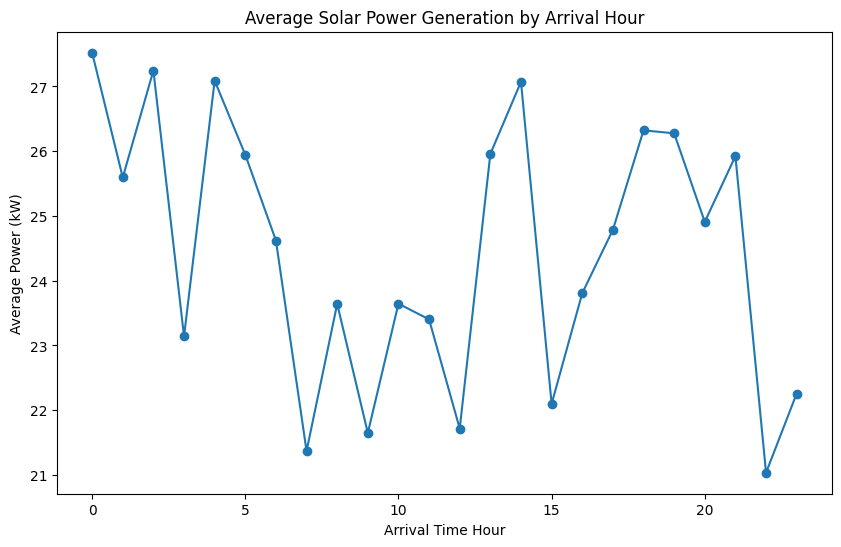

Training features shape: (800, 18)
Testing features shape: (200, 18)
Training target shape: (800,)
Testing target shape: (200,)
Test Mean Squared Error: 9.3900
Test R^2 Score: 0.7662


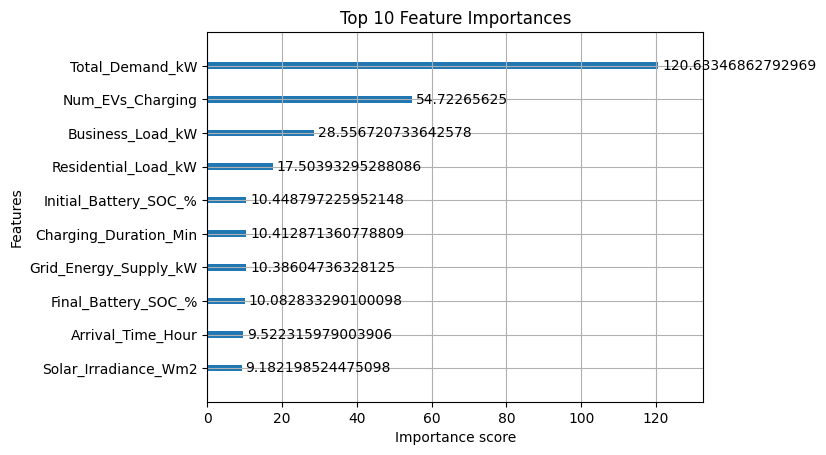

In [36]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
df = pd.read_csv('PV_EV_Charging_Dataset.csv')
print("Dataset shape:", df.shape)
print("\nColumn names:\n", df.columns)
print("\nFirst 5 rows:")
print(df.head())
print("\nMissing values per column:")
print(df.isnull().sum())
print(df.info())

hourly_avg = df.groupby('Arrival_Time_Hour')['Solar_Power_kW'].mean()
plt.figure(figsize=(10,6))
plt.plot(hourly_avg.index, hourly_avg.values, marker='o')
plt.title('Average Solar Power Generation by Arrival Hour')
plt.xlabel('Arrival Time Hour')
plt.ylabel('Average Power (kW)')
plt.show()

df = pd.get_dummies(df, columns=['Charging_Mode'], drop_first=True)
feature_cols = [col for col in df.columns if col != 'Charging_Power_kW' and col != 'Optimal_Charging_Decision']
X = df[feature_cols]
y = df['Charging_Power_kW']

split_index = int(len(df) * 0.8)
X_train, X_test = X.iloc[:split_index,:], X.iloc[split_index:,:]
y_train, y_test = y.iloc[:split_index], y.iloc[split_index:]

print(f"Training features shape: {X_train.shape}")
print(f"Testing features shape: {X_test.shape}")
print(f"Training target shape: {y_train.shape}")
print(f"Testing target shape: {y_test.shape}")

import xgboost as xgb
from sklearn.metrics import mean_squared_error, r2_score

model = xgb.XGBRegressor(
    objective='reg:squarederror',
    n_estimators=100,
    learning_rate=0.1,
    max_depth=6,
    random_state=42
)


model.fit(X_train, y_train)
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Test Mean Squared Error: {mse:.4f}")
print(f"Test R^2 Score: {r2:.4f}")


import matplotlib.pyplot as plt
xgb.plot_importance(model, max_num_features=10, importance_type='gain', title='Top 10 Feature Importances')
plt.show()



In [37]:
import pandas as pd
df = pd.read_csv('PV_EV_Charging_Dataset.csv')

if df.isnull().sum().sum() == 0:
    print("No missing values found.")
else:
    
    df.fillna(df.median(numeric_only=True), inplace=True)
    for col in df.select_dtypes(include=['object']).columns:
        df[col].fillna(df[col].mode()[0], inplace=True)


df['Charging_Mode'] = df['Charging_Mode'].astype('category')


duplicates_count = df.duplicated().sum()
if duplicates_count > 0:
    df.drop_duplicates(inplace=True)
    print(f"Removed {duplicates_count} duplicate rows.")
else:
    print("No duplicate rows found.")



power_cols = ['Solar_Power_kW', 'Charging_Power_kW', 'Grid_Energy_Supply_kW', 'Available_Energy_kW']
for col in power_cols:
    df = df[df[col] >= 0]


df['Charging_Duration_Hours'] = df['Charging_Duration_Min'] / 60


df.to_csv('PV_EV_Charging_Cleaned.csv', index=False)
print("Cleaned dataset saved as PV_EV_Charging_Cleaned.csv")


No missing values found.
No duplicate rows found.
Cleaned dataset saved as PV_EV_Charging_Cleaned.csv


Fitting 3 folds for each of 20 candidates, totalling 60 fits
Best parameters: {'subsample': 1.0, 'n_estimators': 100, 'max_depth': 3, 'learning_rate': 0.1, 'colsample_bytree': 0.8}
Tuned Test Mean Squared Error: 9.5627
Tuned Test R^2 Score: 0.7619
Average 5-Fold CV MSE: 9.5652


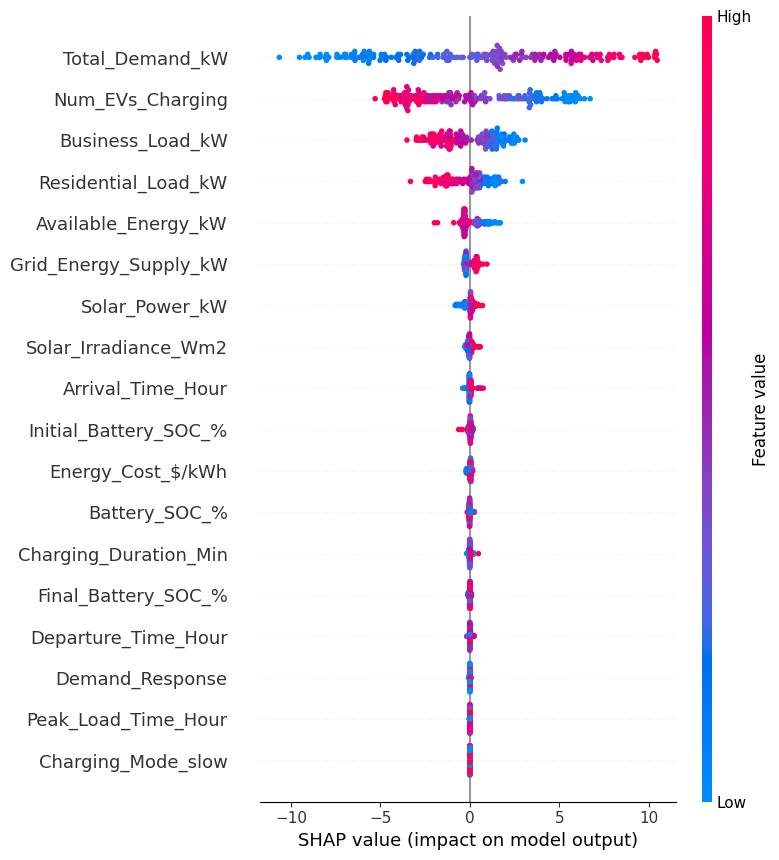

Model saved as xgb_best_model.pkl


In [38]:
from sklearn.model_selection import RandomizedSearchCV, cross_val_score
from sklearn.metrics import mean_squared_error, r2_score
import xgboost as xgb
import shap
import joblib
param_dist = {
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 6, 9],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0]
}

xgb_model = xgb.XGBRegressor(objective='reg:squarederror', random_state=42)

random_search = RandomizedSearchCV(
    xgb_model, param_distributions=param_dist,
    n_iter=20, scoring='neg_mean_squared_error',
    cv=3, verbose=1, random_state=42, n_jobs=-1
)

random_search.fit(X_train, y_train)

print("Best parameters:", random_search.best_params_)

best_model = random_search.best_estimator_

# Evaluate best model on test set
y_pred_best = best_model.predict(X_test)
mse_best = mean_squared_error(y_test, y_pred_best)
r2_best = r2_score(y_test, y_pred_best)

print(f"Tuned Test Mean Squared Error: {mse_best:.4f}")
print(f"Tuned Test R^2 Score: {r2_best:.4f}")
cv_scores = cross_val_score(best_model, X, y, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
print(f"Average 5-Fold CV MSE: {-cv_scores.mean():.4f}")
explainer = shap.Explainer(best_model)
shap_values = explainer(X_test)

shap.summary_plot(shap_values, X_test)


joblib.dump(best_model, 'xgb_best_model.pkl')
print("Model saved as xgb_best_model.pkl")




Predictions on test data:
[13.130701  18.553787  10.761769  13.756764   8.509579  19.14716
  8.461964  18.108091   8.515795   2.048566  15.337879   8.607659
  6.9491653  7.7286644  9.067922   4.989379   8.679707   9.72324
  3.0662885 14.886047   6.936045  19.148848  18.707321   7.6817274
 17.05747   16.358625  11.281942  15.022851   3.9520595 12.197087
 13.48438   15.270414   8.612282   8.899146  16.237772  11.162711
  3.5430357 11.846094  15.937261  12.913326   8.375676  11.304244
 12.316934   8.038937  10.191985  16.768559  16.589436  18.429132
 16.899519  10.644628  11.337969  16.19917   19.344519   8.8199
  9.592395   6.8357096 14.827775  10.621256   7.9660745  5.40429
  8.061491  16.018112   6.771053   7.185054  14.142234  16.02861
  4.3623095 14.401309  14.057557  16.283323  20.088736   6.0113654
 12.751436   7.0776854 10.153056   5.2399597 13.247159  11.016353
  1.3435944  7.5535665 11.529338   4.0637937  9.157093  11.09271
 11.493848  18.022572  12.692113  11.579629   8.760774 

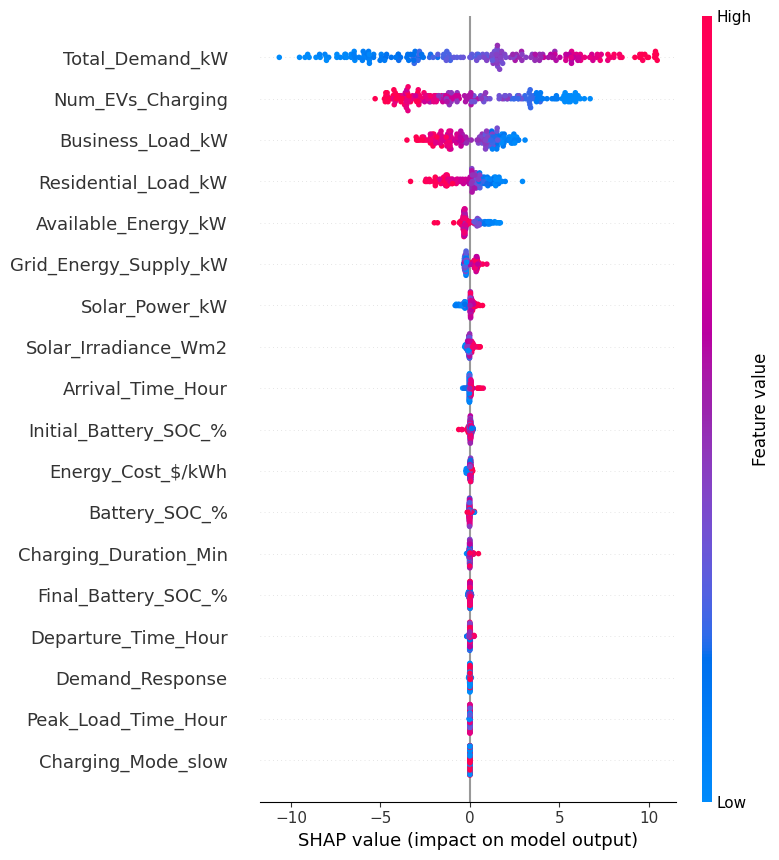

In [39]:
import joblib
import pandas as pd
import shap
import matplotlib.pyplot as plt
best_model = joblib.load('xgb_best_model.pkl')
predictions = best_model.predict(X_test)

print("Predictions on test data:")
print(predictions)

output_df = X_test.copy()
output_df['Predicted_Charging_Power_kW'] = predictions
output_df.to_csv('predictions_output.csv', index=False)
print("Predictions saved to predictions_output.csv")
explainer = shap.Explainer(best_model)
shap_values = explainer(X_test)


shap.summary_plot(shap_values, X_test)




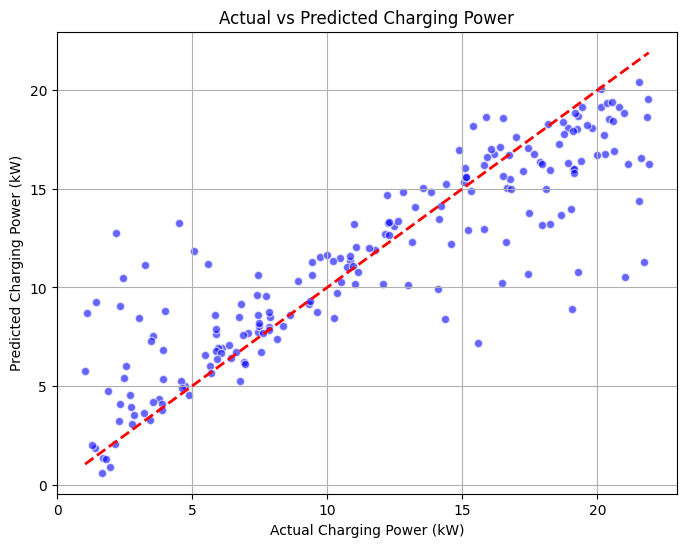

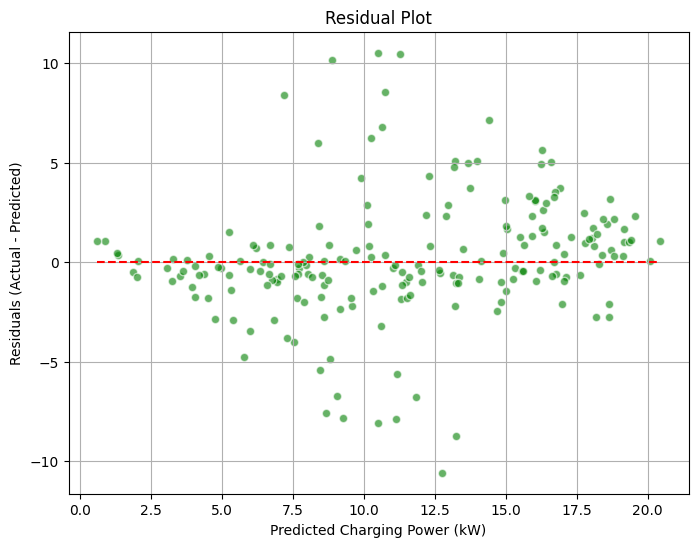

In [40]:
import matplotlib.pyplot as plt
import numpy as np


plt.figure(figsize=(8,6))
plt.scatter(y_test, predictions, alpha=0.6, color='blue', edgecolors='w')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Actual Charging Power (kW)')
plt.ylabel('Predicted Charging Power (kW)')
plt.title('Actual vs Predicted Charging Power')
plt.grid(True)
plt.show()


residuals = y_test - predictions
plt.figure(figsize=(8,6))
plt.scatter(predictions, residuals, alpha=0.6, color='green', edgecolors='w')
plt.hlines(y=0, xmin=predictions.min(), xmax=predictions.max(), colors='red', linestyles='dashed')
plt.xlabel('Predicted Charging Power (kW)')
plt.ylabel('Residuals (Actual - Predicted)')
plt.title('Residual Plot')
plt.grid(True)
plt.show()


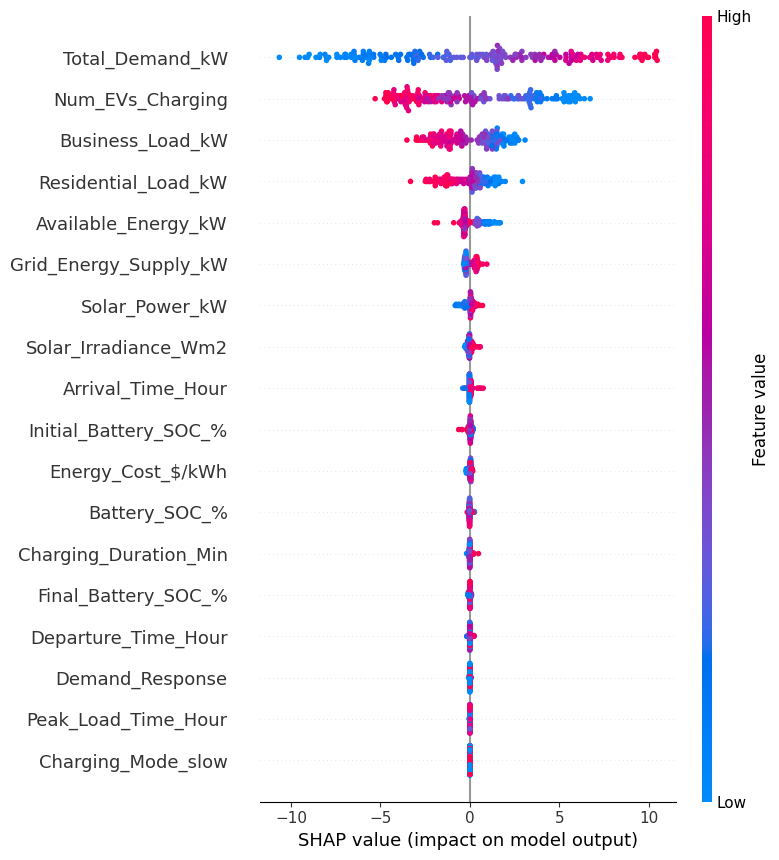

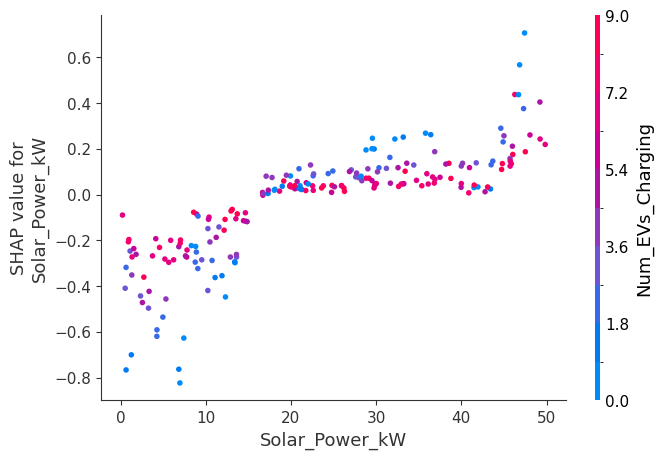

In [41]:
import shap
import matplotlib.pyplot as plt
import joblib


best_model = joblib.load('xgb_best_model.pkl')


explainer = shap.Explainer(best_model)
shap_values = explainer(X_test)


shap.summary_plot(shap_values, X_test)


important_feature = X_test.columns[0]  
shap.dependence_plot(important_feature, shap_values.values, X_test)



